In [ ]:
#hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Walkthrough
> A start-to-end example showing how `gingado` contributes to the machine learning workflow

Let's use `gingado` to implement a machine learning model that seeks to predict multiple exchange rates at the same time. 

### Obtaining the data

The main dataset of interest is the EUR exchange rate against a set of other currencies. It is obtainable from the European Central Bank. Let's download the data using the SDMX protocol to ensure we are using trusted data from the official source and according to a definition that is compatible with the needs of this walk-through. If you are interested in how this dataset was compiled, please refer to `load_EURFX_data` function.

If you want to know more about how you can use SDMX with python, or understand the details of this particular data request, consider visiting the [pandasdmx documentation](https://pandasdmx.readthedocs.io/en/v1.0/walkthrough.html). Note that this particular dataset was selected to illustrate this section because it is the similar to the example in the `pandasdmx` documentation, so that readers can refer to that material if more detail is needed.

In [ ]:
from gingado.utils import load_EURFX_data
EUR_FX = load_EURFX_data()

Before proceeding, let's plot the series to confirm that they were downloaded properly, and also to get a visual idea of how they vary over time.

array([[<AxesSubplot:xlabel='TIME_PERIOD'>,
        <AxesSubplot:xlabel='TIME_PERIOD'>],
       [<AxesSubplot:xlabel='TIME_PERIOD'>,
        <AxesSubplot:xlabel='TIME_PERIOD'>],
       [<AxesSubplot:xlabel='TIME_PERIOD'>,
        <AxesSubplot:xlabel='TIME_PERIOD'>],
       [<AxesSubplot:xlabel='TIME_PERIOD'>,
        <AxesSubplot:xlabel='TIME_PERIOD'>]], dtype=object)

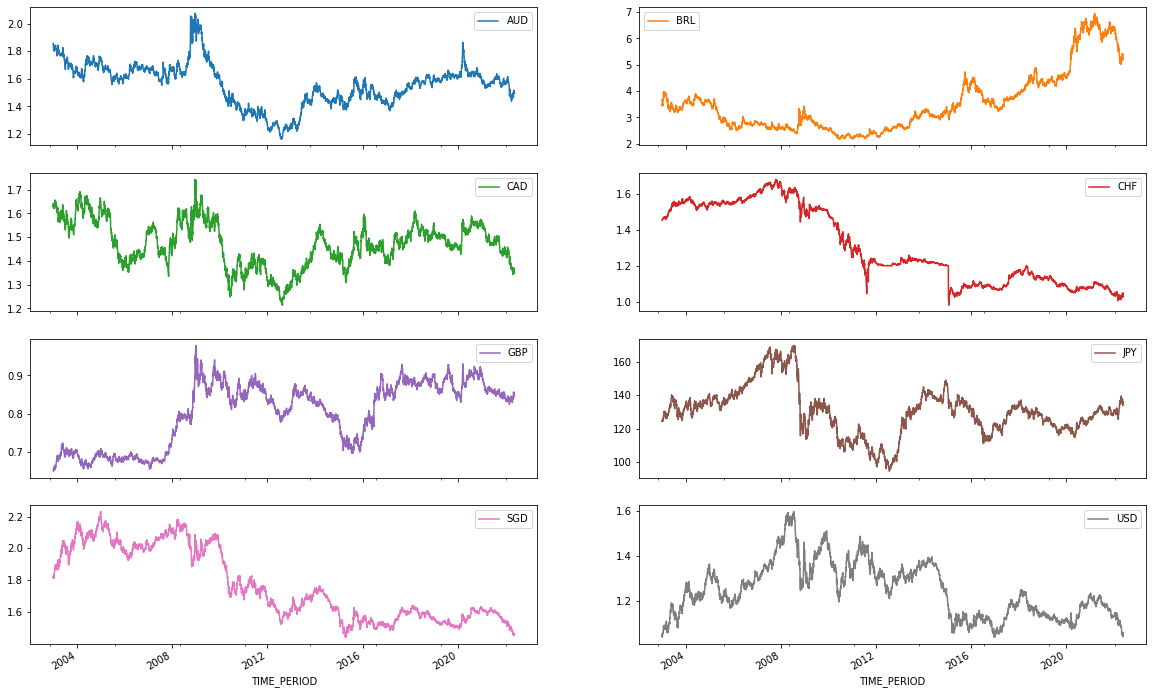

In [ ]:
EUR_FX.plot(subplots=True, layout=(4, 2), figsize=(20, 13))

### `gingado`'s first contribution: Augmenting data

The user now might want to add more data to the original dataset. This would offer the machine learning model a more rich set of inputs from which to uncover relationships that will help better predict the dataset of interest.

`gingado` helps the user augment its original dataset using the SDMX to fetch relevant data from official sources. But first, let's do it step by step.

#### Preliminaries
This phase entails importing the necessary libraries and defining the source(s), frequency and starting period for the statistical data to be downloaded.

In [ ]:
import pandas as pd
from sklearn.feature_selection import VarianceThreshold

sources = ['ECB']
key = {"FREQ": EUR_FX.index.to_series().diff().min().resolution_string}

params = {"startPeriod": '2003-01-01'}

#### Downloading the additional data

During this step, the information is sought after from the official sources, and added to the original dataset provided by the user.

#### Cleaning the augmented dataset

It is plausible that some of the newly downloaded data might not be useful for the user. For example, they might not vary during the desired time period, or they might be collinear to the original dataset provided by the user. So this step entails removing any instances where this occurs in the augmented dataset.

### Augmenting the dataset with `gingado`

These steps listed above are wrapped under a custom object, `AugmentSDMX`.

The code below verifies that the manually-augmented dataset described above (`augm_df`) is exactly the same as a dataset augmented with `AugmentSent`.

In [ ]:
# from pandas.testing import assert_frame_equal

# assert_frame_equal(augm_df, augm_X, check_dtype=True)

### Ensuring that the X variable has a conducive format formating with series

Now that the original dataset is accompanied by more data, `gingado` offers a function that ensures the X data is in the appropriate format, including with respect to any number of lags to be added in the data.

One difference that time series models have compared to other datasets is that it is not straightforwrad to do an appropriate training/testing split. The reason for this is because the testing dataset may still require information from the training dataset dates (assuming a date cut-off) when the model have lags. This is obviously different from the problem where a model with timestamps needs to put in the testing dataset only the most recent information - when lags are involved, the target variable indeed should only comprise the most recent ones, but the features can plausibly contain information from before the date cut-off. 

In [ ]:
from gingado.utils import Lag

For example, say we want to consider four lags *after jumping 2 periods* (for example, to ensure that the prediction can really achieve good out-of-sample performance):

In [ ]:
import numpy as np
jump = 2
nlag = 4

X = np.random.rand(8, 3)

lagger=Lag(lags=nlag, jump=jump).fit_transform(X=X)
X, lagger

NameError: name 'Lag' is not defined

The object `lagger`, an instance of `gingadoLag`, behaves like a `scitkit-learn` transformer: